## 3.7 Can a network learn $\beta_i^{RD}$?

The above show comparisons between FD, RD and BP for the case where we can estimate $\beta_i^{RD}$ offline, using whatever regression methods we like. We would like to implement this estimation in an online fashion, using a simple model a neuron/network may be able to mimic.

From Section 2.3 we simulate a second network whose output will be used to approximate $\beta_i^{RD}$.

In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

#%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rand
from sklearn.kernel_ridge import KernelRidge
from sklearn import linear_model
from pandas.plotting import autocorrelation_plot as autocorr
import pandas as pd

from lib.lif import LIF, ParamsLIF, LSM, ParamsLSM, LSM_const
from lib.causal import causaleffect, causaleffect_linear

Populating the interactive namespace from numpy and matplotlib


In [97]:
q = 3              #Dimension of learnt vector
dt = 0.001         #Simulation timestep
DeltaT = 20        #Number of timebins over which learning rule is applied
tsim = 60             #Total simulation time
T = (tsim/dt)/DeltaT #Number of learning blocks
N = 50             #Number of repeated simulations
c = 0.5           #Correlation coefficient
x = 0              #Input
n = 2              #Number of neurons
sigma = 10         #Their noise level
mu = 1             #Threshold
tau = 1            #Neuron timescale
eta = .2           #Learning rate
p = 0.1           #Learning window
tau_s = 0.020      #Output filter timescale

w1 = 2
w2 = 6

B1 = 3
B2 = 300
x = 1
y = 0.12
z = -0.3

cost_fun = lambda s1, s2: (B1*s1-x)**2 + (z+B2*s2 - B2*(B1*s1-y)**2)**2

In [98]:
#Create two LIF neurons and train them to learn beta_i^{RD}
params_lif = ParamsLIF(sigma = sigma, tau = tau, mu = mu, c = c)
lif = LIF(params_lif, t = tsim)
lif.W = np.array([w1, w2])
lif.x = 0

t_filter = np.linspace(0, 1, 2000)
exp_filter = np.exp(-t_filter/tau_s)
exp_filter = exp_filter/np.sum(exp_filter)
ds = exp_filter[0]

## Keeping a constant input $x$

In [99]:
(v_raw, h_raw, _, _) = lif.simulate()
h_raw.shape

(2, 60000)

In [104]:
#Also collect the c_abv, c_below for p = 0.03, p = 1, accumulated over each epoch, and estimate 
#the 'true' beta as we go
c1_abv_p = np.zeros(0)
c1_abv_1 = np.zeros(0)
c1_blo_p = np.zeros(0)
c1_blo_1 = np.zeros(0)

c2_abv_p = np.zeros(0)
c2_abv_1 = np.zeros(0)
c2_blo_p = np.zeros(0)
c2_blo_1 = np.zeros(0)

beta_rd_true = np.zeros((n, T, N))
beta_fd_true = np.zeros((n, T, N))
beta_rd = np.zeros((n, T, N))

for idx in range(N):
    count = 0
    print("N=%d"%idx)
    #Simulate LIF
    (v_raw, h_raw, _, _) = lif.simulate()
    s1 = np.convolve(h_raw[0,:], exp_filter)[0:h_raw.shape[1]]
    s2 = np.convolve(h_raw[1,:], exp_filter)[0:h_raw.shape[1]]
    
    V = np.zeros((n, q))
    
    abvthr = np.zeros(n)
    blothr = np.zeros(n)
    
    cost_raw = cost_fun(s1, s2)
    #Break the simulation and voltage into blocks
    nB = h_raw.shape[1]/DeltaT
    hm = h_raw.reshape((n, nB, DeltaT))
    vm = v_raw.reshape((n, nB, DeltaT))
    #print nB
    #print DeltaT
    #print cost_raw.shape
    
    v = np.max(vm, 2)
    h = np.max(hm, 2)
    cost_r = cost_raw.reshape((nB, DeltaT))
    cost = np.squeeze(cost_r[:,-1])

    #Then just repeat the learning rule as before
    dV = np.zeros(V.shape)
    bt = [False, False]
    for t in range(nB):
        for k in range(n):
            if (v[k,t] < mu):
                if k == 0:
                    c1_blo_1 = np.hstack((c1_blo_1, cost[t]))
                else:
                    c2_blo_1 = np.hstack((c2_blo_1, cost[t]))
            if (v[k,t] >= mu):
                if k == 0:
                    c1_abv_1 = np.hstack((c1_abv_1, cost[t]))
                else:
                    c2_abv_1 = np.hstack((c2_abv_1, cost[t]))

            if (v[k,t] > mu - p) & (v[k,t] < mu):
                if k == 0:
                    c1_blo_p = np.hstack((c1_blo_p, cost[t]))
                else:
                    c2_blo_p = np.hstack((c2_blo_p, cost[t]))
                blothr[k] += 1
                if bt[k] == False:
                    #ahat = np.array([1, 0, -(v[k,t]-mu)])
                    ahat = np.array([1, 0, 0])
                    dV[k,:] += (np.dot(V[k,:], ahat)+cost[t])*ahat                    
                    bt[k] = True
            elif (v[k,t] < mu + p) & (v[k,t] >= mu):
                if k == 0:
                    c1_abv_p = np.hstack((c1_abv_p, cost[t]))
                else:
                    c2_abv_p = np.hstack((c2_abv_p, cost[t]))
                abvthr[k] += 1
                #Only do the update when firing...
                if bt[k] == True:
                    #ahat = np.array([1, (v[k,t]-mu), 0])
                    ahat = np.array([1, 0, 0])
                    dV[k,:] += (np.dot(V[k,:], ahat)-cost[t])*ahat                                        
                    count += 1
                    V[k,:] = V[k,:] - eta*dV[k,:]#*count/(count+1)
                    dV[k,:] = np.zeros((1,q))
                    bt[k] = False
                
            beta_rd[k,t,idx] = V[k,0]
        beta_rd_true[0,t,idx] = np.mean(c1_abv_p)-np.mean(c1_blo_p)
        beta_rd_true[1,t,idx] = np.mean(c2_abv_p)-np.mean(c2_blo_p)
        beta_fd_true[0,t,idx] = np.mean(c1_abv_1)-np.mean(c1_blo_1)
        beta_fd_true[1,t,idx] = np.mean(c2_abv_1)-np.mean(c2_blo_1)

#Test how well we learnt beta through an extra second of simulation
print("N = %d. Unit 1. Above thr %d: Below thr: %d. Percent above: %2.2f"%(idx, abvthr[0], blothr[0], 100*float(abvthr[0])/(blothr[0]+abvthr[0])))
print("N = %d. Unit 2. Above thr %d: Below thr: %d. Percent above: %2.2f"%(idx, abvthr[1], blothr[1], 100*float(abvthr[1])/(blothr[1]+abvthr[1])))


N=0
N=1
N=2
N=3
N=4
N=5
N=6
N=7
N=8
N=9
N=10
N=11
N=12
N=13
N=14
N=15
N=16
N=17
N=18
N=19
N=20
N=21
N=22
N=23
N=24
N=25
N=26
N=27
N=28
N=29
N=30
N=31
N=32
N=33
N=34
N=35
N=36
N=37
N=38
N=39
N=40
N=41
N=42
N=43
N=44
N=45
N=46
N=47
N=48
N=49
N = 49. Unit 1. Above thr 9: Below thr: 46. Percent above: 16.36
N = 49. Unit 2. Above thr 156: Below thr: 140. Percent above: 52.70


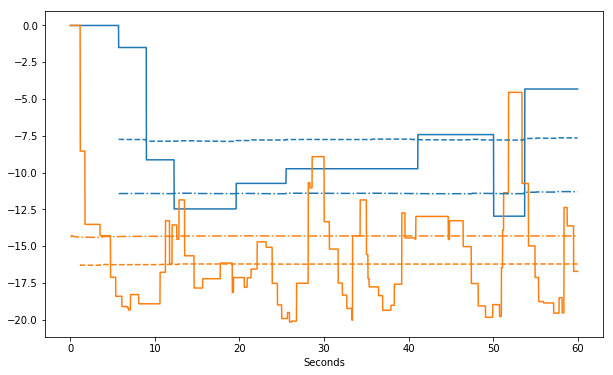

In [110]:
T = int(T)
ts = np.arange(T).astype(float)/T*tsim
#Plot the learning progress
plt.plot(ts, (2*beta_rd[0,:,0]), ts, 2*(beta_rd[1,:,0]));
plt.plot(ts, np.mean(beta_rd_true[0,:,:], 1), '--C0', ts, np.mean(beta_rd_true[1,:,:],1), '--C1');
plt.plot(ts, np.mean(beta_fd_true[0,:,:], 1), '-.C0', ts, np.mean(beta_fd_true[1,:,:],1), '-.C1');
plt.xlabel("Seconds")
#plt.plot(range(T), beta_fd_true[0,:,0], '-.C0', range(T), beta_fd_true[1,:,0], '-.C1');

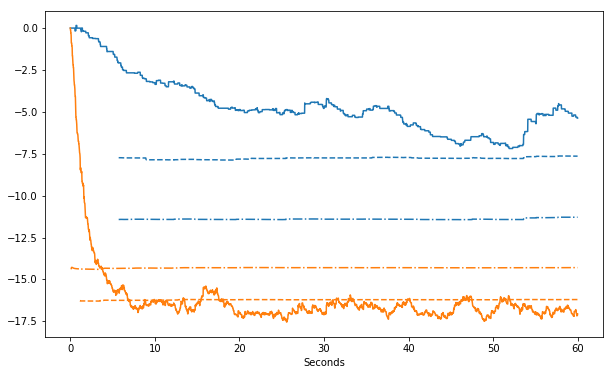

In [111]:
T = int(T)
ts = np.arange(T).astype(float)/T*tsim
#Plot the learning progress
plt.plot(ts, np.mean(2*beta_rd[0,:,:], 1), ts, 2*np.mean(beta_rd[1,:,:], 1));
plt.plot(ts, np.mean(beta_rd_true[0,:,:], 1), '--C0', ts, np.mean(beta_rd_true[1,:,:],1), '--C1');
plt.plot(ts, np.mean(beta_fd_true[0,:,:], 1), '-.C0', ts, np.mean(beta_fd_true[1,:,:],1), '-.C1');
plt.xlabel("Seconds")
#plt.plot(cost)

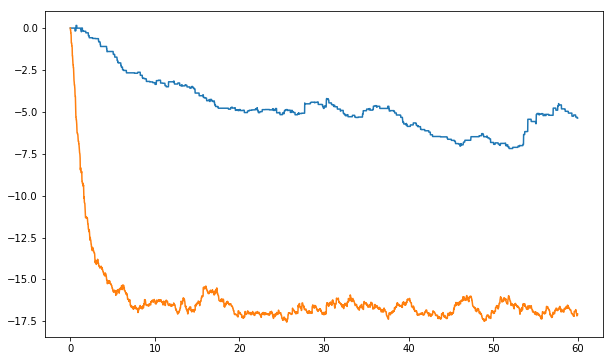

In [106]:
plt.plot(ts, np.mean(2*beta_rd[1,:,:], 1), ts, 2*np.mean(beta_rd[1,:,:], 1));

In [ ]:
T

From which we see the weights for both units learn the right values. The dot-dashed lines are the FD estimator, the dashed line is the RD estimator, and the solid curve is the learned weights through SGD -- they should approximate the RD estimator. The solid and flat curves are the 'true' BP gradient.

We can also estimate parameters of a linear model for which to estimate $\beta$. How should this work?

Thus the LSM learns the cost gradient after only a few 'epochs'. Shown here is the output with highly correlated input, in which the RD estimator is able to distinguish its effect on the cost from its neighbor.